In [1]:
# Import some basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
# A helper function for downloading files
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)

# Hands-on Activity 16.4: Diagnostics for Classifications

## Objectives

+ To assess the qualtity of a classification model

## High melting explosives sensitivity
Let's repeat what we did for the HMX example, but after splitting the dataset into training and validation subsets.
We will be making predictions on the validation subset.

num_train = 42, num_valid = 18


<ipython-input-2-49d04950faa5>:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train = train_data[:, 0].astype(np.float)
<ipython-input-2-49d04950faa5>:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = train_

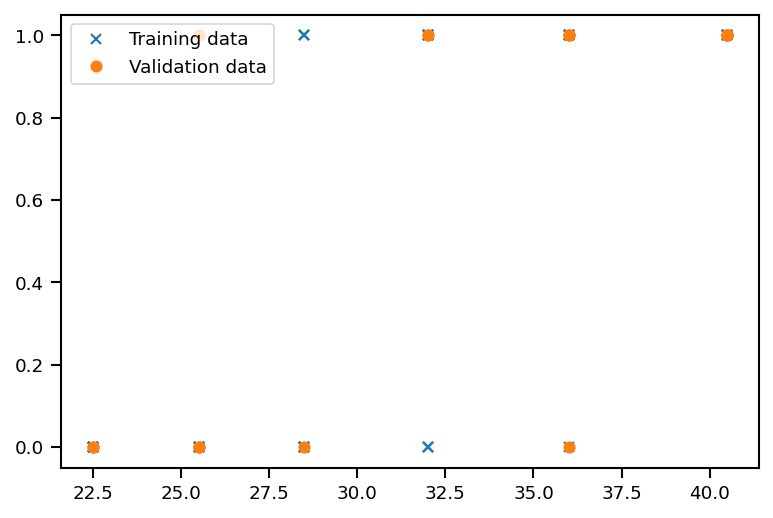

In [2]:
# Download the data file:
url = 'https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/activities/hmx_data.csv'
download(url)
# Load the data using pandas
import pandas as pd
data = pd.read_csv('hmx_data.csv')
# Extract data for regression
# Heights as a numpy array
x = data['Height'].values
# The labels must be 0 and 1
# We will use a dictionary to indicate our labeling
label_coding = {'E': 1, 'N': 0}
y = np.array([label_coding[r] for r in data['Result']])
data['y'] = y

# Separate data into training and validation
num_obs = x.shape[0]
# Select what percentage you want to put in the training data
train_percentage = 0.7
# Figure out how many training points you are going to use:
num_train = int(num_obs * train_percentage)
# Figure out how many validation points you are going to use:
num_valid = num_obs - num_train
print('num_train = {0:d}, num_valid = {1:d}'.format(num_train, num_valid))

# Before splitting the data, randomly permute rows
permuted_data = np.random.permutation(data)
# Split
train_data = permuted_data[:num_train] # This picks the first n_train rows
valid_data = permuted_data[num_train:] # This puts the rest on the validation rows
# Get the x's and the y's for regression
x_train = train_data[:, 0].astype(np.float)
y_train = train_data[:, 2].astype(np.int)
x_valid = valid_data[:, 0].astype(np.float)
y_valid = valid_data[:, 2].astype(np.int)
# Let's plot the training and the validation datasets in different colors
fig, ax = plt.subplots(dpi=150)
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_valid, y_valid, 'o', label='Validation data')
plt.legend(loc='best');

In [8]:
from sklearn.linear_model import LogisticRegression

def get_polynomial_design_matrix(x, degree):
    """
    Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

# Make the design matrix
degree = 5
Phi_train = get_polynomial_design_matrix(x_train[:, None], degree)
model = LogisticRegression(penalty='none', fit_intercept=False).fit(Phi_train, y_train)

# Make predictions on the validation data:
Phi_valid = get_polynomial_design_matrix(x_valid[:, None], degree)
predictions = model.predict_proba(Phi_valid)

Let's now make some decisions using the approach we presented in the previous hands-on activity:

In [9]:
# c_00 = cost of correctly picking 0 when 0 is true
# c_01 = cost of wrongly picking 0 when 1 is true
# c_11 = cost of correctly picking 1 when 1 is true
# c_10 = cost of wrongly picking 1 when 0 is true
cost_matrix = np.array(
[[0.0, 1.0],
 [1.0, 0.0]]
)
# Expected cost of each decision for each validation point (num_valid x 2 matrix)
exp_cost = np.einsum('ij,ki->kj', cost_matrix, predictions)
# And now let's make all the decisions for all validation points at once:
y_pred = np.argmin(exp_cost, axis=1)
print(y_pred)

[0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 1 0 0]


First, let's calculate the accuracy score:

In [10]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_valid, y_pred)
print('HMX Accuracy = {0:1.2f} %'.format(acc * 100))

HMX Accuracy = 77.78 %


Not bad. But let's also look at the balanced accuracy score:

In [11]:
from sklearn.metrics import balanced_accuracy_score
bacc = balanced_accuracy_score(y_valid, y_pred)
print('HMX balanced accuracy = {0:1.2f} %'.format(bacc * 100))

HMX balanced accuracy = 79.22 %


Now, let's look at the confusion matrix:

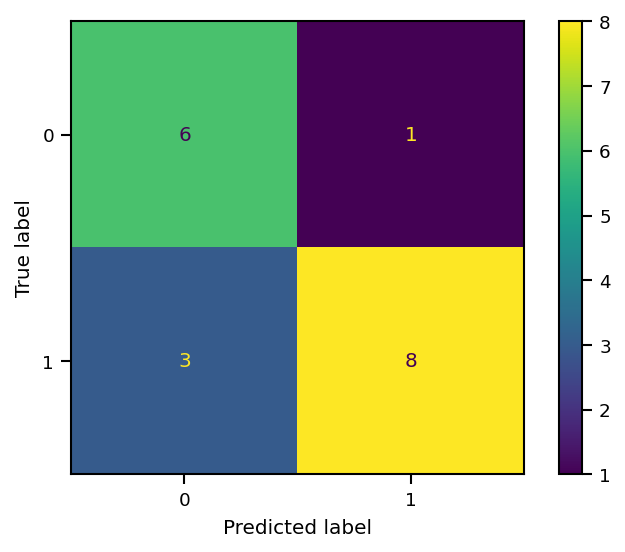

In [12]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
fig, ax = plt.subplots(dpi=150)
plot_confusion_matrix(model, Phi_valid, y_valid, ax=ax)

### Questions

+ Repeat the analysis above with a higher degree polynomial, say 5. Is the result better or worse? Why?